In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import itertools as it
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})

In [2]:
variants_file = "/data5/UK_Biobank/annotations/vep/2022_03_13/data/variants_by_gene/lof_missense_pred_freq_0.01.tsv"
phenotypes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/samples_with_residuals.csv"
icd_file = "/data5/deepro/ukbiobank/papers/bmi_project/1_parse_data/prepare_icd_codes/data/ukb30075_icd10.csv"

In [3]:
combinations_files = [
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv",
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"
    ]

In [4]:
def get_merged_combo_file(combo_files):
    combo_dfs = [pd.read_csv(cf) for cf in combo_files]
    combo_df = pd.concat(combo_dfs)
    return combo_df

In [5]:
combo_df = get_merged_combo_file(combinations_files)

In [6]:
variants_df = pd.read_csv(variants_file, sep="\t", low_memory=False, usecols=["Sample", "variant_id", "Gene", "SYMBOL", "Mut_type"], dtype=str)
phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], dtype={"eid": str, "bmi": np.float64})
icd_df = pd.read_csv(icd_file, low_memory=False, dtype={"eid": str})

In [7]:
variant_type_dict = {"eid":[], "vtype":[]}

for uci in combo_df.unique_combo_id:
    genes = uci.split("_")
    svdf = variants_df.loc[(variants_df.Gene.isin(genes))]
    for group in svdf.groupby("Sample"):
        # if the set of genes is present in the sample variant df, that means the sample contains the combo
        if set(genes).issubset(set(group[1].Gene)):
            variant_type_dict["eid"].append(group[0])
            variant_type_dict["vtype"].append("-".join(sorted(group[1].Mut_type.unique())))

In [8]:
# adding Quantile_rank column to the DataFrame
decile_cut = pd.qcut(phenotypes_df['bmi'], 10, labels = False, retbins=True)
phenotypes_df['Decile_rank'] = decile_cut[0]

In [9]:
vtype_bmi_df = pd.DataFrame(variant_type_dict).merge(phenotypes_df, left_on="eid", right_on="eid")

In [20]:
save_sample_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/white_british/data/enrichment/icd/combosamples_bmidecile1to3.txt"

with open(save_sample_file, "w") as f:
    for sample in vtype_bmi_df.loc[vtype_bmi_df.Decile_rank<3, "eid"]:
        f.write(f"{sample}\n")

In [21]:
all_sample_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/white_british/data/enrichment/icd/allsamples_bmidecile1to3.txt"

with open(all_sample_file, "w") as f:
    for sample in phenotypes_df.loc[phenotypes_df.Decile_rank<3, "eid"]:
        f.write(f"{sample}\n")

In [11]:
profile_df = vtype_bmi_df.merge(icd_df, left_on="eid", right_on="eid")

In [12]:
icd_columns = list(icd_df.columns)[1:]

In [15]:
profile_df.loc[profile_df.bmi>29]

,eid,vtype,bmi,Decile_rank,41202-0.0,41202-0.1,41202-0.2,41202-0.3,41202-0.4,41202-0.5,...,41204-0.174,41204-0.175,41204-0.176,41204-0.177,41204-0.178,41204-0.179,41204-0.180,41204-0.181,41204-0.182,41204-0.183
0,1326452,missense,35.61130,9,G560,M1995,M7986,N303,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1373844,lof-missense,31.97200,8,C64,H269,H358,T814,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2051742,lof-missense,44.61120,9,D320,D329,F432,G918,H160,K529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2369124,missense,34.72960,9,G560,K625,M179,M720,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2395237,missense,31.21750,8,I849,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,2809945,missense,32.58260,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1149,3385805,missense,32.57170,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1150,3506147,missense,34.21600,9,I846,J459,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1154,4837408,missense,34.22910,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
profile_df

,eid,vtype,bmi,Decile_rank,41202-0.0,41202-0.1,41202-0.2,41202-0.3,41202-0.4,41202-0.5,...,41204-0.174,41204-0.175,41204-0.176,41204-0.177,41204-0.178,41204-0.179,41204-0.180,41204-0.181,41204-0.182,41204-0.183
0,1326452,missense,35.61130,9,G560,M1995,M7986,N303,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1373844,lof-missense,31.97200,8,C64,H269,H358,T814,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2051742,lof-missense,44.61120,9,D320,D329,F432,G918,H160,K529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2369124,missense,34.72960,9,G560,K625,M179,M720,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2395237,missense,31.21750,8,I849,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,5187507,missense,26.77900,5,N950,R194,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157,5312084,missense,31.53875,8,I839,M179,M2323,M2333,R074,Z302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1158,5518706,missense,21.08120,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159,5770663,missense,24.95910,3,M2416,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
vtype_bmi_df["Diagnosis"] = ~profile_df.loc[:, icd_columns].isna().all(axis=1)

In [126]:
vtype_bmi_df.groupby("Decile_rank").count().reset_index()

,Decile_rank,eid,vtype,bmi
0,0,31,31,31
1,1,27,27,27
2,2,39,39,39
3,3,64,64,64
4,4,60,60,60
5,5,72,72,72
6,6,69,69,69
7,7,126,126,126
8,8,336,336,336
9,9,337,337,337


In [169]:
sns.color_palette("ch:s=0,r=2,l=0.95,d=.3", 10).as_hex()

['#eef4fa',
 '#cdeae1',
 '#bddbb7',
 '#c5bd95',
 '#cf9a94',
 '#bc7fac',
 '#8a78b5',
 '#517a97',
 '#35755e',
 '#395c29']

In [179]:
sns.color_palette("light:deepskyblue", 10).as_hex()

['#eff1f3',
 '#d5ebf4',
 '#bae6f5',
 '#9fe0f7',
 '#85dbf8',
 '#6ad5fa',
 '#50d0fb',
 '#34cafc',
 '#1ac4fe',
 '#00bfff']

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:xlabel='BMI', ylabel='Number of individuals'>)

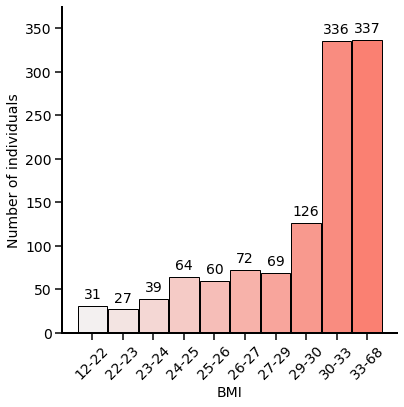

In [191]:
def create_decile_rank_plot(df, decile_extremes):
    fig,ax = plt.subplots(1,1,figsize=(6, 6))
    ax.bar(df.Decile_rank, df.eid, width=0.97, color=sns.color_palette("light:salmon", 10).as_hex(), edgecolor="k")
    xticklabels = ["-".join([str(int(decile_extremes[i])), str(int(decile_extremes[i+1]))]) for i in range(10)]
    ax.set_xticks(range(10),xticklabels, rotation=45, ha="center", fontsize=14)
    ax.set_xlabel("BMI")
    ax.set_ylabel("Number of individuals")
    # g.bar_label([g.containers[i] for i in range])
    rects = ax.patches
    # Make some labels.
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, f"{height}", ha="center", va="bottom"
        )
    ax.set_ylim(0, 375)
    ax.spines[['right', 'top']].set_visible(False)
    return fig,ax

create_decile_rank_plot(vtype_bmi_df.groupby("Decile_rank").count().reset_index(), decile_cut[1])

In [130]:
all_icd_list = sum([icds.split(",") for icds in profile_df.loc[profile_df.Decile_rank<=2, icd_columns].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1).values.flatten() if icds], [])

In [91]:
vtype_bmi_df

,eid,vtype,bmi,Decile_rank,Decile_label,Diagnosis
0,1326452,missense,35.61130,9,33.3984 - 68.9505,True
1,1373844,lof-missense,31.97200,8,30.70712 - 33.3984,True
2,2051742,lof-missense,44.61120,9,33.3984 - 68.9505,True
3,2369124,missense,34.72960,9,33.3984 - 68.9505,True
4,2395237,missense,31.21750,8,30.70712 - 33.3984,True
...,...,...,...,...,...,...
1156,5187507,missense,26.77900,5,26.6948 - 27.7857,True
1157,5312084,missense,31.53875,8,30.70712 - 33.3984,True
1158,5518706,missense,21.08120,0,12.1212 - 22.112,False
1159,5770663,missense,24.95910,3,24.6559 - 25.683,True


In [97]:
icd_bmi_df = vtype_bmi_df.groupby("Decile_rank").agg({"Diagnosis": sum, "eid": len})
icd_bmi_df["No_diagnosis"] = icd_bmi_df.eid - icd_bmi_df.Diagnosis

In [104]:
icd_bmi_df

,Diagnosis,eid,No_diagnosis
Decile_rank,,,
0,25,31,6
1,23,27,4
2,31,39,8
3,57,64,7
4,53,60,7
5,62,72,10
6,60,69,9
7,110,126,16
8,286,336,50


In [102]:
icd_bmi_df.loc[:, ["No_diagnosis", "Diagnosis"]].T.values

array([[  6,   4,   8,   7,   7,  10,   9,  16,  50,  41],
       [ 25,  23,  31,  57,  53,  62,  60, 110, 286, 296]])

In [95]:
from scipy.stats import chi2_contingency

In [103]:
chi2_contingency(icd_bmi_df.loc[:, ["No_diagnosis", "Diagnosis"]].T.values)

(4.237518033045606,
 0.8950956572727011,
 9,
 array([[  4.21877692,   3.6744186 ,   5.30749354,   8.70973299,
           8.16537468,   9.79844961,   9.39018088,  17.14728682,
          45.72609819,  45.86218777],
        [ 26.78122308,  23.3255814 ,  33.69250646,  55.29026701,
          51.83462532,  62.20155039,  59.60981912, 108.85271318,
         290.27390181, 291.13781223]]))

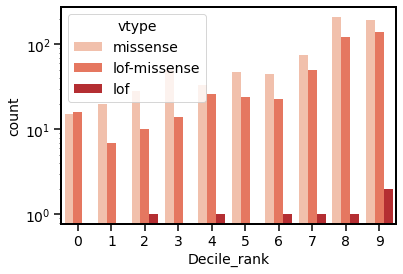

In [15]:
g = sns.countplot(data=vtype_bmi_df, x="Decile_rank", hue="vtype", palette="Reds", )
g.set_yscale("log")

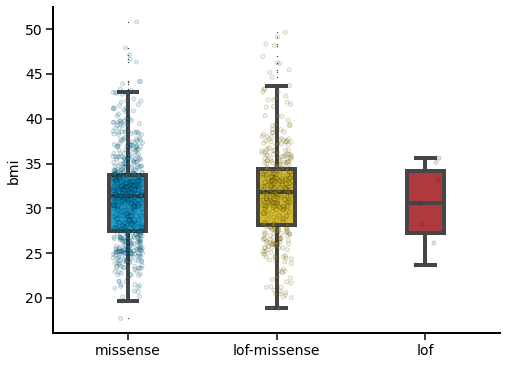

In [16]:
boxdf = vtype_bmi_df

# Define Canvas
fig,ax = plt.subplots(1, 1, figsize=(8, 6))

# Box Plot
sns_strip = sns.stripplot(
    data=boxdf,
    palette=["#00ADEE", "#eecc16", "#c1272d", ],  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    x="vtype",
    y="bmi",
    order=["missense", "lof-missense", "lof"],
    orient="v",
    s=4,
    alpha=0.15, ec='black', linewidth=1, jitter=True, facecolors="none", dodge=False, ax=ax 
    )

sns_box = sns.boxplot(
    data=boxdf,
    palette=["#00ADEE", "#eecc16", "#c1272d", ],  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    x="vtype",
    y="bmi",
    order=["missense", "lof-missense", "lof"],
    hue_order=["missense", "lof-missense", "lof"],
    dodge=False, width=0.25, linewidth=4, fliersize=0.5)


# Adjust Axis
# ax.set_yticks([-0.02, 0, 0.02, 0.04])
# ax.set_ylim((-0.025, 0.05))
# ax.set_ylabel('Percentage')
# ax.set_xticklabels(["Akbari\ngenes", "Turcot\ngenes", "Digenic\ncombinations", "Trigenic\ncombinations", ], rotation=0)
ax.set_xlabel("")

# Remove Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [17]:
for test_vars in list(it.combinations(vtype_bmi_df.vtype.unique(), 2)):
    bmi_g1 = vtype_bmi_df.loc[vtype_bmi_df.vtype==test_vars[0], "bmi"]
    bmi_g2 = vtype_bmi_df.loc[vtype_bmi_df.vtype==test_vars[1], "bmi"]
    print(f"Testing {test_vars[0]} vs {test_vars[1]}")
    print(ttest_ind(bmi_g1, bmi_g2))

Testing missense vs lof-missense
Ttest_indResult(statistic=-2.0402606732858475, pvalue=0.04155203247447314)
Testing missense vs lof
Ttest_indResult(statistic=0.41068712172784744, pvalue=0.6814229852633193)
Testing lof-missense vs lof
Ttest_indResult(statistic=0.7013571697486168, pvalue=0.4834534578453238)
